# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs

In this notebook, you will:
- represent each paragraph as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong topic/scene shifts
- connect this to how LLM systems segment long documents
  into chunks for retrieval and long-context reasoning.


In [1]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. Load Data ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    
    # Optional: Clean headers if needed
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

fellowship_text = load_book('../data/Fellowship.txt')
towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

c:\Users\vlads\OneDrive\Desktop\nlp\applied-NLP-week1-drafts1\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Patched for 'The King')
    Forces a split on EVERY newline to handle varying file formats.
    """
    # 1. Normalize all newlines to standard \n
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # 2. Split on EVERY single newline (Aggressive Mode)
    # This works for The King (single lines) AND Fellowship (double lines)
    # because empty strings from double lines get filtered out below.
    paras = text.split('\n')
    
    # 3. Clean and Filter
    # We lowered min_words to 5 to catch short dialogue like "Yes." or "No."
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        # Skip empty lines or tiny artifacts
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Calculate similarity between paragraph[i] and paragraph[i+1]"""
    if not paragraphs: return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

In [3]:
fellowship_paras = split_into_paragraphs(fellowship_text)
towers_paras = split_into_paragraphs(towers_text)
king_paras = split_into_paragraphs(king_text)

f_drift = topic_drift_embeddings(fellowship_paras)
t_drift = topic_drift_embeddings(towers_paras)
k_drift = topic_drift_embeddings(king_paras)

print(f"Fellowship Mean Similarity: {np.mean(f_drift):.3f}")
print(f"Two Towers Mean Similarity: {np.mean(t_drift):.3f}")
print(f"The King Mean Similarity:   {np.mean(k_drift):.3f}")

Fellowship Mean Similarity: 0.384
Two Towers Mean Similarity: 0.401
The King Mean Similarity:   0.414


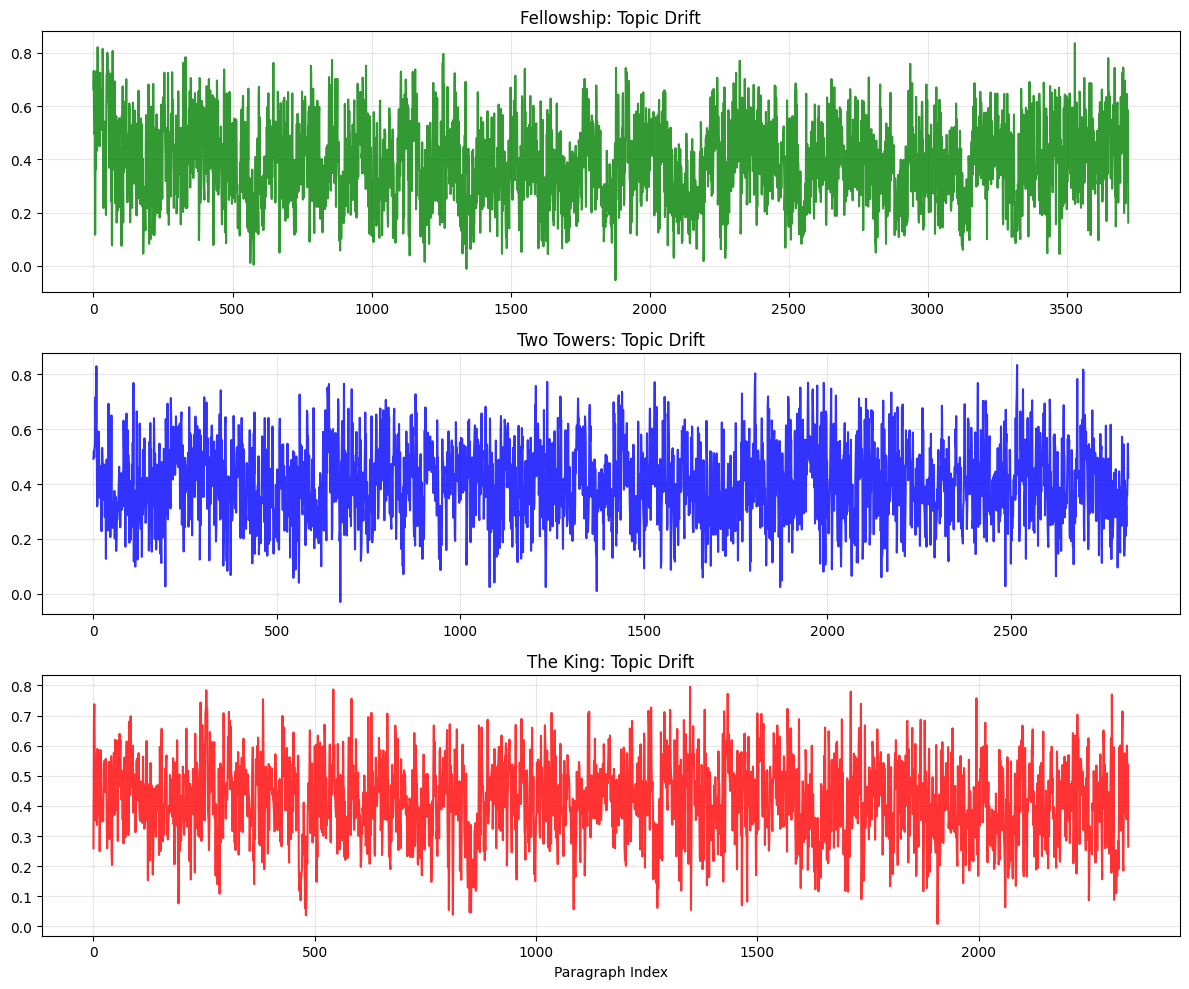

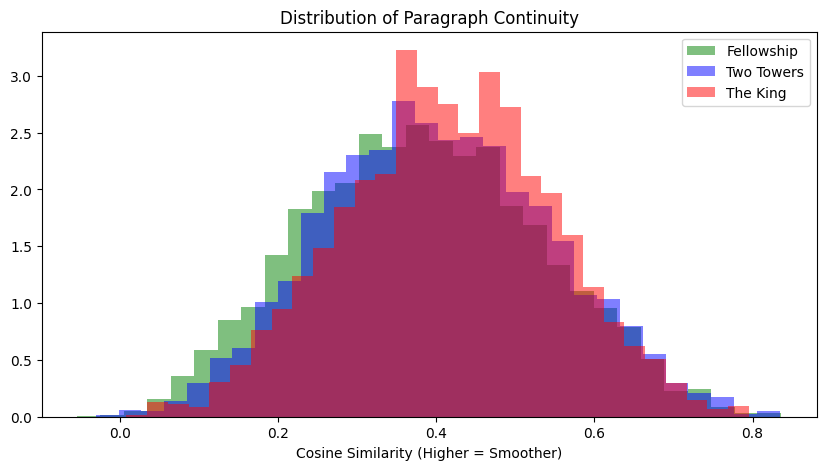

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axes[0].plot(f_drift, alpha=0.8, color='green')
axes[0].set_title('Fellowship: Topic Drift')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_drift, alpha=0.8, color='blue')
axes[1].set_title('Two Towers: Topic Drift')
axes[1].grid(True, alpha=0.3)

axes[2].plot(k_drift, alpha=0.8, color='red')
axes[2].set_title('The King: Topic Drift')
axes[2].set_xlabel('Paragraph Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(f_drift, bins=30, alpha=0.5, label='Fellowship', density=True, color='green')
ax.hist(t_drift, bins=30, alpha=0.5, label='Two Towers', density=True, color='blue')
ax.hist(k_drift, bins=30, alpha=0.5, label='The King', density=True, color='red')
ax.set_title('Distribution of Paragraph Continuity')
ax.set_xlabel('Cosine Similarity (Higher = Smoother)')
ax.legend()
plt.show()

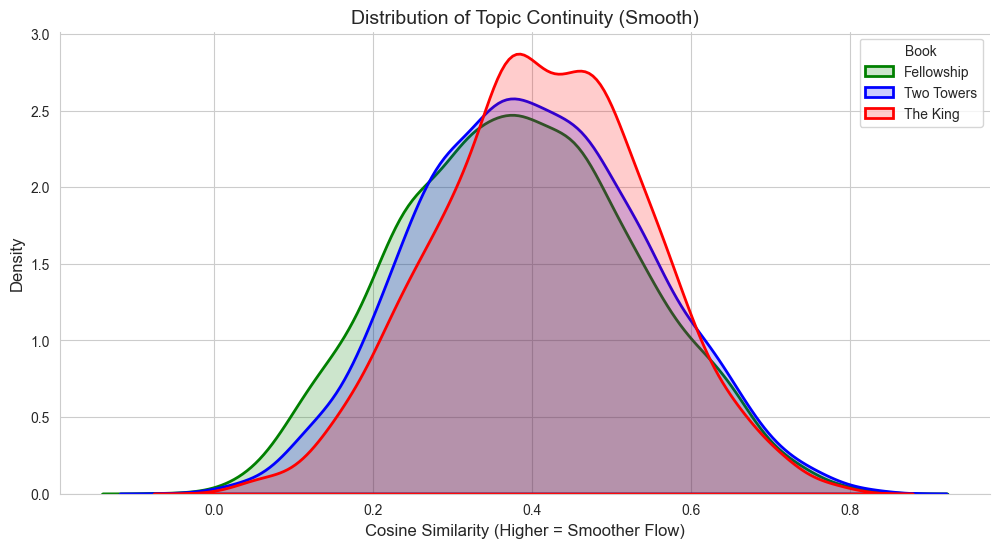

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Smooth Curves (KDE)
sns.kdeplot(f_drift, fill=True, color='green', label='Fellowship', alpha=0.2, linewidth=2, ax=ax)
sns.kdeplot(t_drift, fill=True, color='blue', label='Two Towers', alpha=0.2, linewidth=2, ax=ax)
sns.kdeplot(k_drift, fill=True, color='red', label='The King', alpha=0.2, linewidth=2, ax=ax)

ax.set_title('Distribution of Topic Continuity (Smooth)', fontsize=14)
ax.set_xlabel('Cosine Similarity (Higher = Smoother Flow)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(title='Book')

# Clean up the border
sns.despine()

plt.show()

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [ ]:
del fellowship_text, towers_text, king_text
del fellowship_paras, towers_paras, king_paras
del f_drift, t_drift, k_drift
del model
gc.collect()

c:\Users\vlads\OneDrive\Desktop\nlp\applied-NLP-week1-drafts1\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing Fellowship...
Processing Two Towers...
Processing The King...


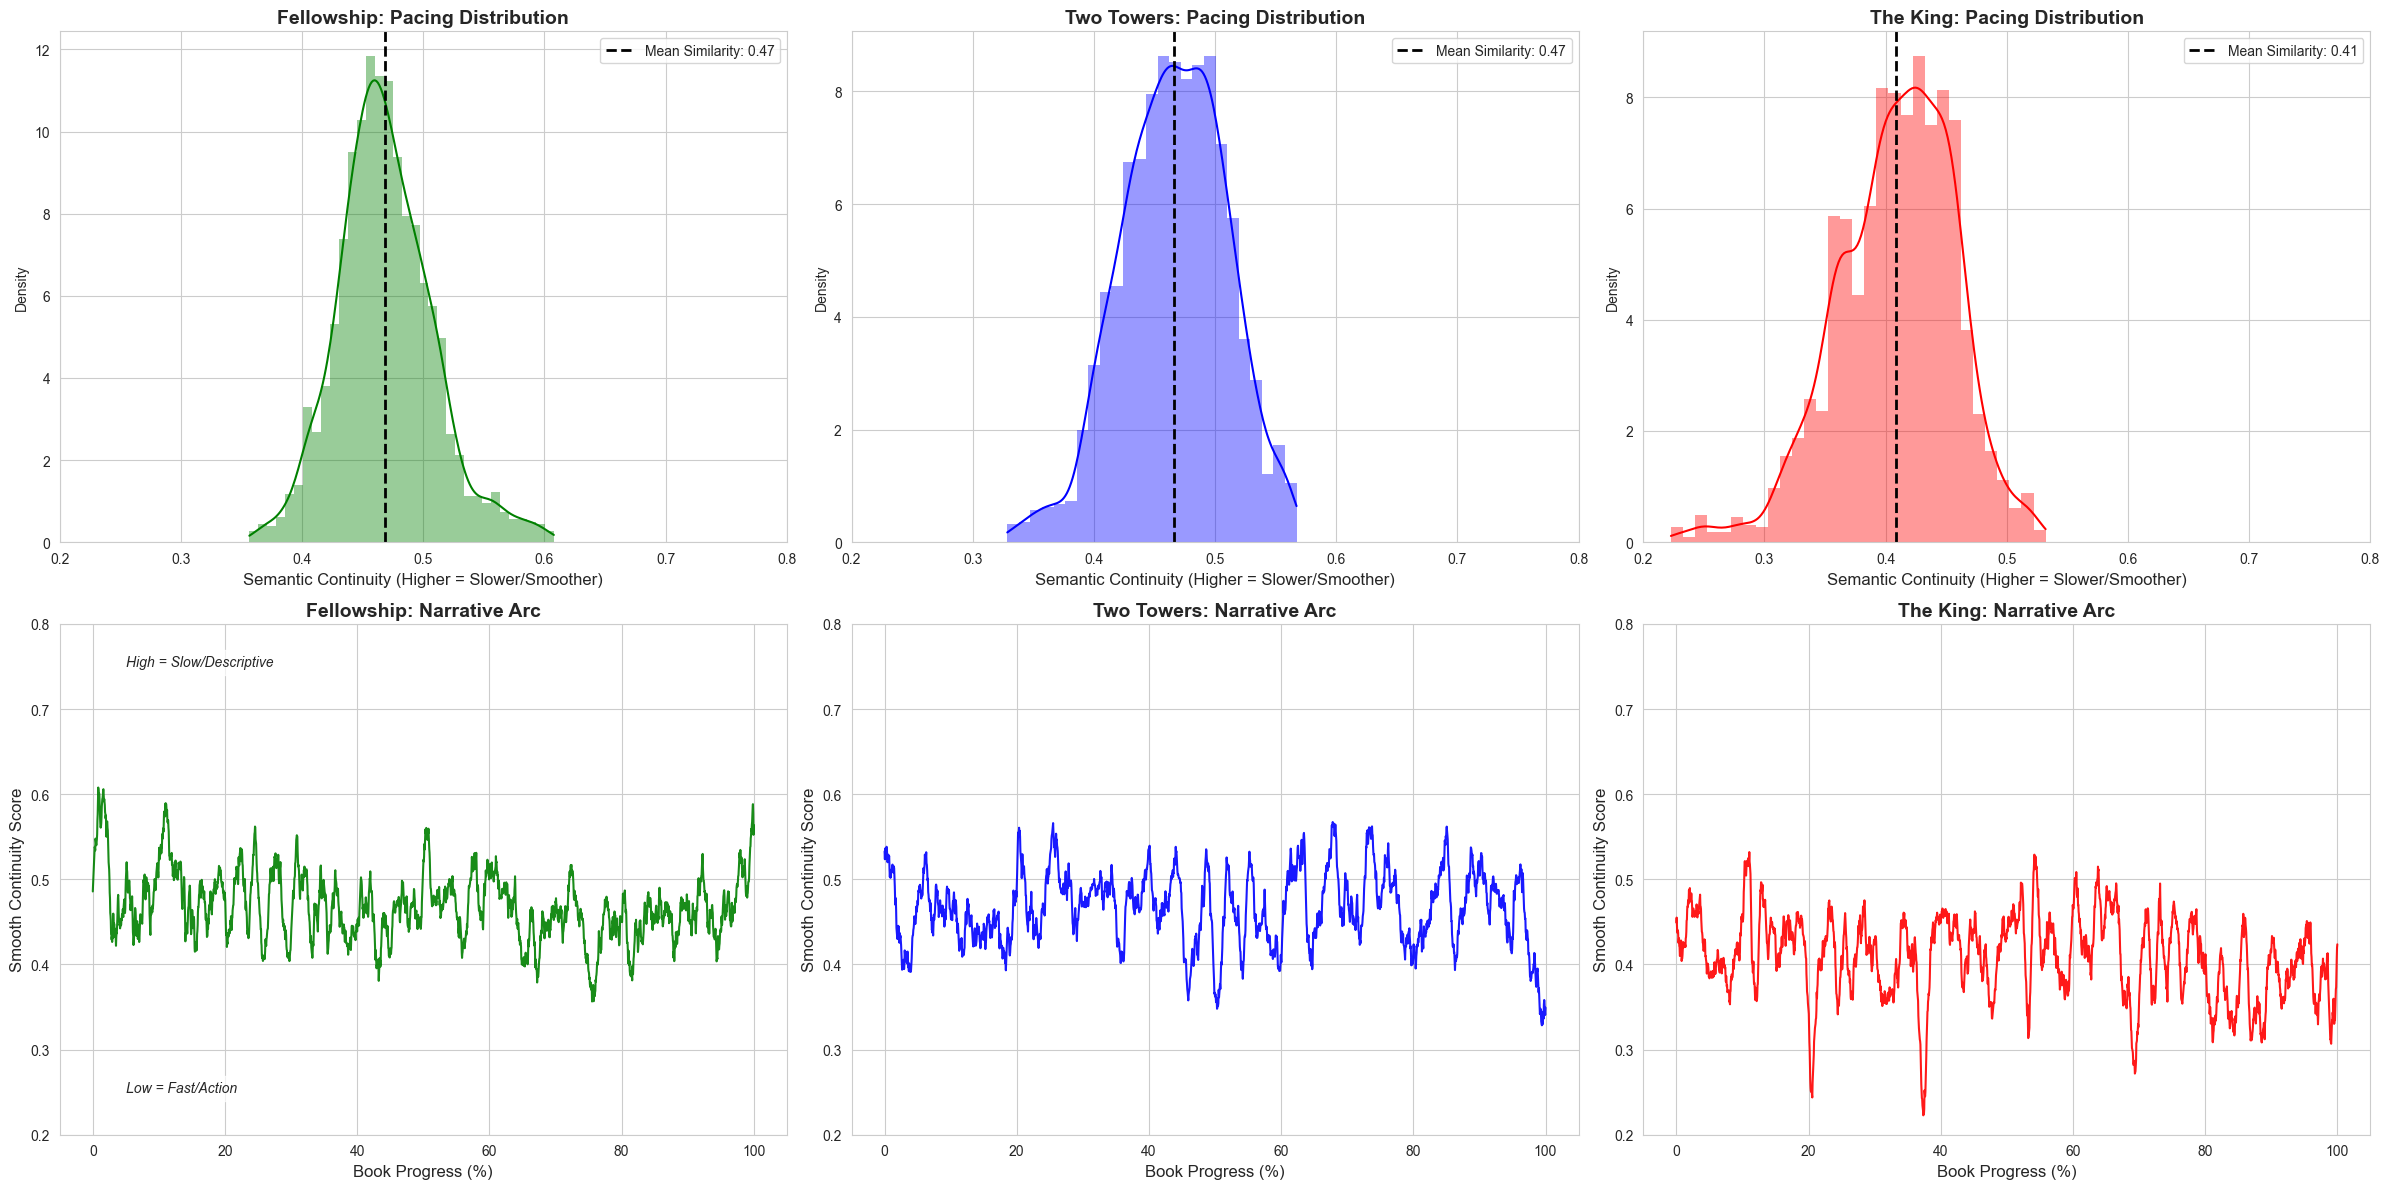

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: ROBUST LOADING & SPLITTING ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Aggressive)
    Splits on every newline to handle all formatting types safely.
    """
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    paras = text.split('\n') # Nuclear split
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

# --- PART 2: DRIFT ANALYSIS WITH SMOOTHING ---
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def calculate_drift(paragraphs: List[str]) -> List[float]:
    """Calculates the similarity between para[i] and para[i+1]."""
    if not paragraphs: return []
    
    embs = model.encode(paragraphs)
    sims = []
    for i in range(len(embs) - 1):
        sim = cosine_similarity(embs[i], embs[i+1])
        sims.append(sim)
    return sims

def get_smoothed_data(raw_data: List[float], window: int = 20) -> List[float]:
    """
    Applies a Rolling Average to smooth out 'Dialogue Ping-Pong'.
    Window=20 means we look at the trend of ~20 paragraphs at a time.
    """
    series = pd.Series(raw_data)
    # Rolling mean centers the window to align with narrative time
    smoothed = series.rolling(window=window, center=True).mean()
    # Drop NaNs created at the start/end
    return smoothed.dropna().tolist()

# --- PART 3: EXECUTION ---
books = [
    ('Fellowship', '../data/Fellowship.txt'),
    ('Two Towers', '../data/TwoTowers.txt'),
    ('The King', '../data/TheKing.txt')
]

results = {}

for name, path in books:
    print(f"Processing {name}...")
    paras = split_into_paragraphs(load_book(path))
    
    # 1. Calculate Raw Drift
    raw_drift = calculate_drift(paras)
    
    # 2. Smooth the data for visualization
    # We use a window of 25 paragraphs to see the "Scene Level" flow
    smooth_drift = get_smoothed_data(raw_drift, window=25)
    
    results[name] = {
        'raw': raw_drift,
        'smooth': smooth_drift,
        'length': len(raw_drift)
    }

# --- PART 4: VISUALIZATION (SEPARATE PANELS) ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}
order = ['Fellowship', 'Two Towers', 'The King']

# ROW 1: DISTRIBUTION (KDE)
# Shows the "Pacing Profile" of each book
for i, name in enumerate(order):
    ax = axes[0, i]
    data = results[name]['smooth']
    color = colors[name]
    
    sns.histplot(data, ax=ax, color=color, kde=True, stat="density", linewidth=0, alpha=0.4)
    
    mean_val = np.mean(data)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean Similarity: {mean_val:.2f}')
    
    ax.set_title(f"{name}: Pacing Distribution", fontsize=14, fontweight='bold')
    ax.set_xlabel("Semantic Continuity (Higher = Slower/Smoother)", fontsize=12)
    ax.set_xlim(0.2, 0.8)
    ax.legend()

# ROW 2: NARRATIVE ARC (Line Plots)
# Shows how the pacing changes from Chapter 1 to the End
for i, name in enumerate(order):
    ax = axes[1, i]
    data = results[name]['smooth']
    color = colors[name]
    
    # Create an X-axis representing % of the book
    x_axis = np.linspace(0, 100, len(data))
    
    ax.plot(x_axis, data, color=color, linewidth=1.5, alpha=0.9)
    
    ax.set_title(f"{name}: Narrative Arc", fontsize=14, fontweight='bold')
    ax.set_xlabel("Book Progress (%)", fontsize=12)
    ax.set_ylabel("Smooth Continuity Score", fontsize=12)
    ax.set_ylim(0.2, 0.8)
    
    # Add annotation for reading the graph
    if i == 0:
        ax.text(5, 0.75, "High = Slow/Descriptive", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))
        ax.text(5, 0.25, "Low = Fast/Action", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

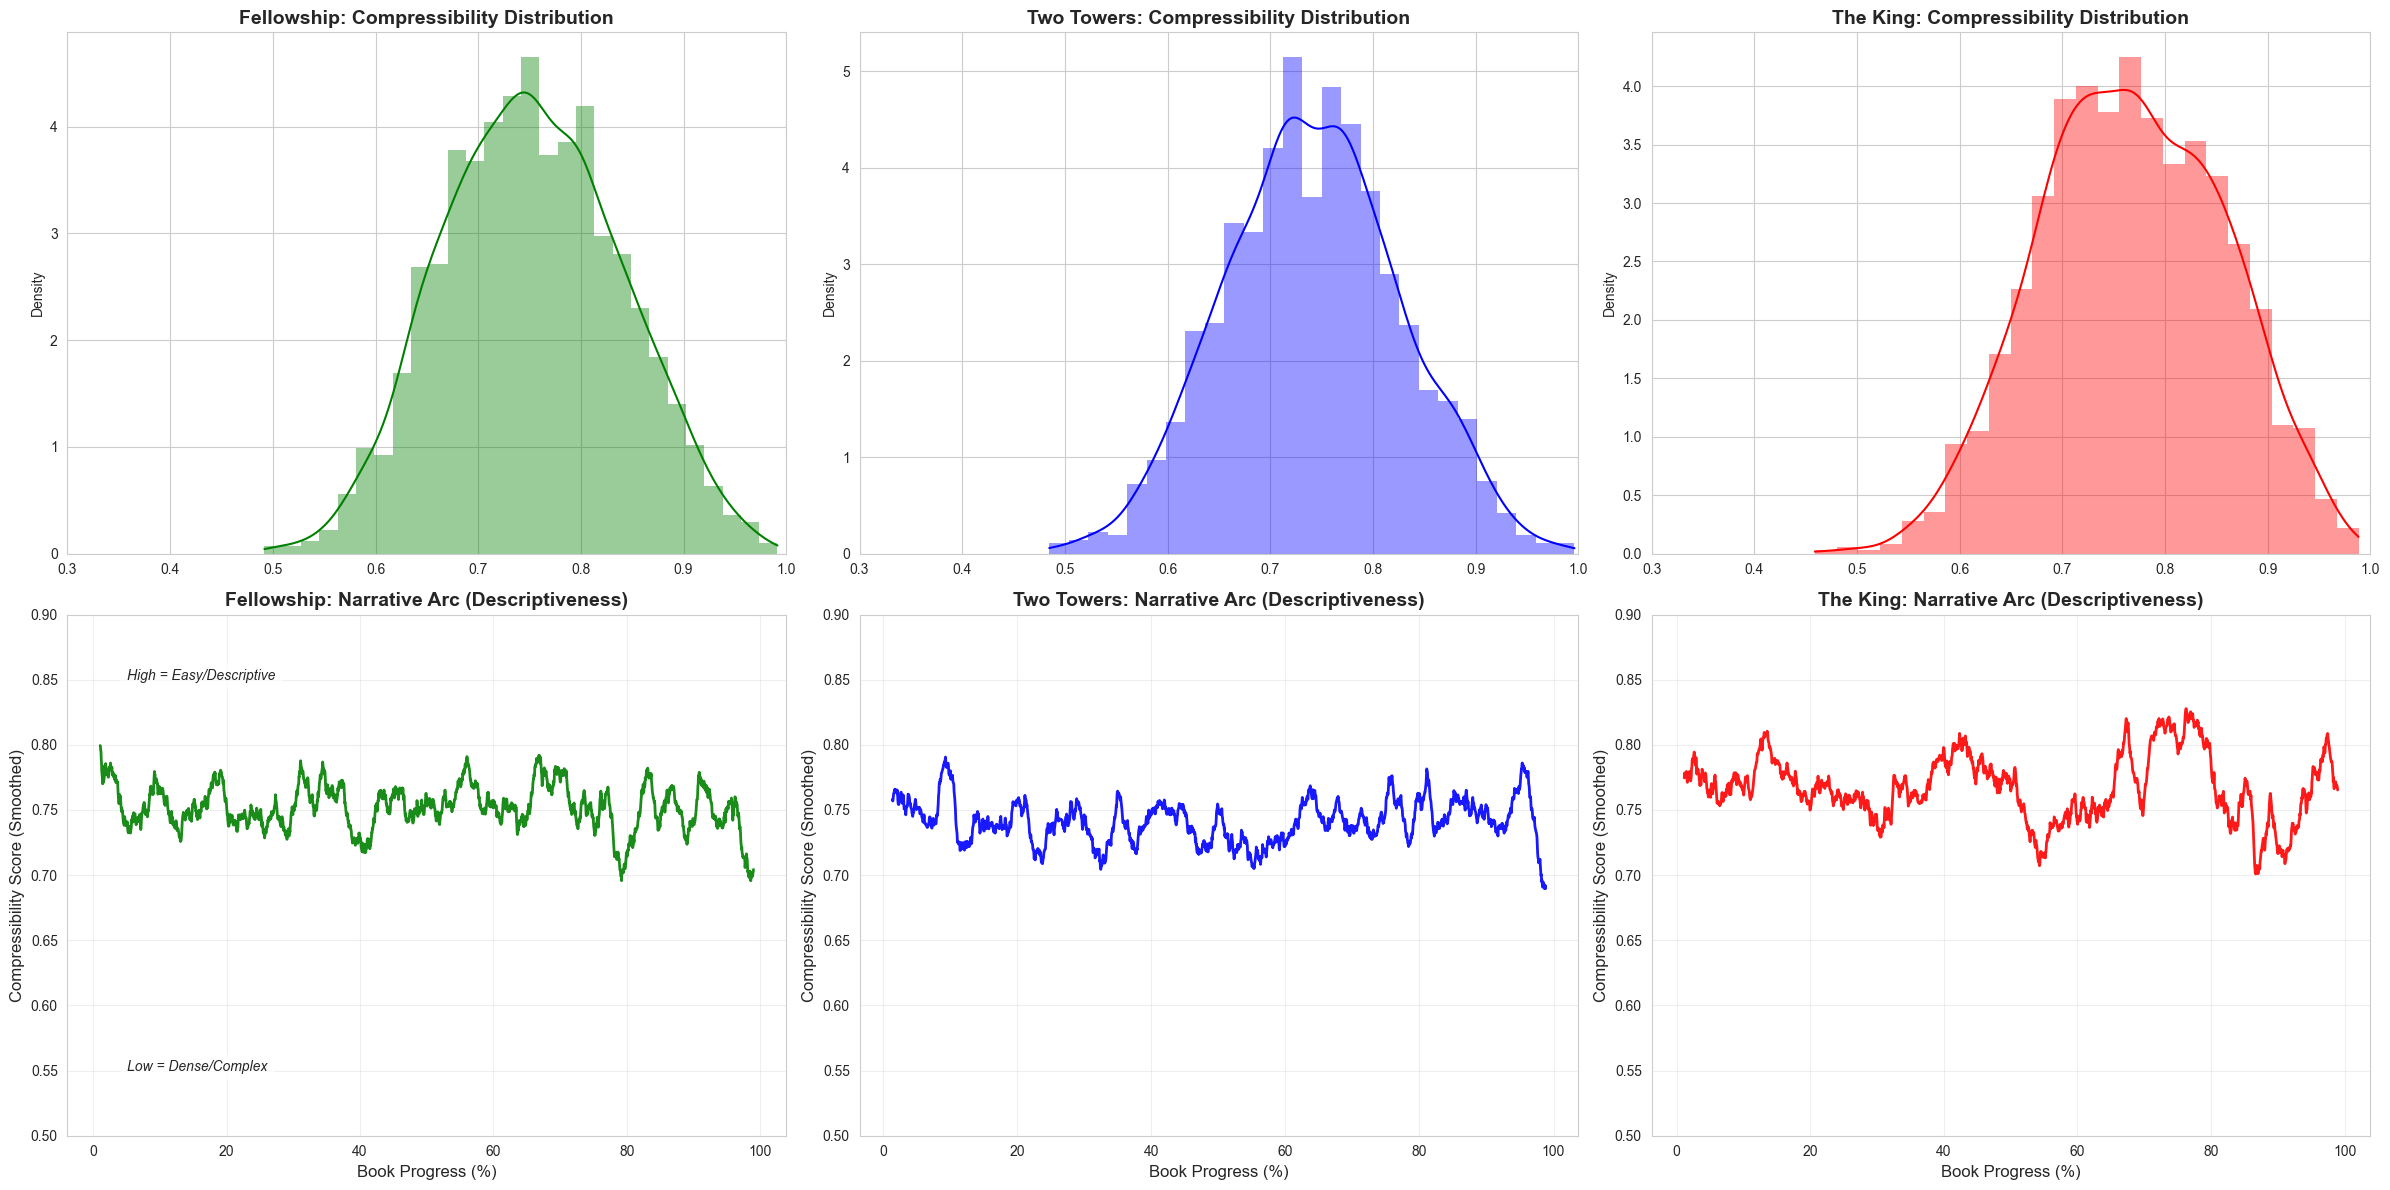

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from sentence_transformers import SentenceTransformer
import gc

model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1 & 2: LOADING & METRICS (Same as before) ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError: return ""
    if 'CHAPTER I' in text: text = text[text.find('CHAPTER I'):]
    return text.strip()

def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    paras = re.split(r'\n\s*\n+', text)
    if len(paras) < 100: paras = text.split('\n')
    cleaned = [p.strip() for p in paras if len(p.strip().split()) >= min_words]
    return cleaned

def get_centroid_compressibility(paragraph: str) -> float:
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', paragraph.strip())
    sents = [s.strip() for s in sentences if s.strip()]
    
    if len(sents) < 2 or len(paragraph.split()) < 20: return None

    para_emb = model.encode(paragraph)
    sent_embs = model.encode(sents)
    
    scores = []
    for s_emb in sent_embs:
        denom = (np.linalg.norm(para_emb) * np.linalg.norm(s_emb))
        sim = float(np.dot(para_emb, s_emb) / denom) if denom != 0 else 0.0
        scores.append(sim)
    return max(scores)

def analyze_book(path):
    paras = split_into_paragraphs(load_book(path))
    scores = []
    for p in paras:
        score = get_centroid_compressibility(p)
        if score is not None: scores.append(score)
        else: scores.append(np.nan) # Keep place for timing, filter later
    return scores

# --- HELPER: SMOOTHING ---
def get_smoothed_data(data: List[float], window: int = 50) -> List[float]:
    series = pd.Series(data)
    # Fill NaNs (trivial paragraphs) with interpolation for smooth lines
    return series.interpolate().rolling(window=window, center=True).mean().tolist()

# --- PART 3: EXECUTION ---
f_data = analyze_book('../data/Fellowship.txt')
t_data = analyze_book('../data/TwoTowers.txt')
k_data = analyze_book('../data/TheKing.txt')

# --- PART 4: VISUALIZATION (WITH NARRATIVE ARC) ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

data_map = [('Fellowship', 'green', f_data), ('Two Towers', 'blue', t_data), ('The King', 'red', k_data)]

# ROW 1: DISTRIBUTION
for i, (name, color, data) in enumerate(data_map):
    ax = axes[0, i]
    valid_data = [d for d in data if not np.isnan(d)]
    sns.histplot(valid_data, ax=ax, color=color, kde=True, stat="density", linewidth=0, alpha=0.4)
    ax.set_title(f"{name}: Compressibility Distribution", fontsize=14, fontweight='bold')
    ax.set_xlim(0.3, 1.0)

# ROW 2: NARRATIVE ARC
for i, (name, color, data) in enumerate(data_map):
    ax = axes[1, i]
    smooth_data = get_smoothed_data(data, window=50)
    x_axis = np.linspace(0, 100, len(data))
    
    ax.plot(x_axis, smooth_data, color=color, linewidth=2, alpha=0.9)
    
    ax.set_title(f"{name}: Narrative Arc (Descriptiveness)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Book Progress (%)", fontsize=12)
    ax.set_ylabel("Compressibility Score (Smoothed)", fontsize=12)
    ax.set_ylim(0.5, 0.9) # Fixed scale
    ax.grid(True, alpha=0.3)
    
    # Annotation
    if i == 0:
        ax.text(5, 0.85, "High = Easy/Descriptive", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))
        ax.text(5, 0.55, "Low = Dense/Complex", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

Processing Fellowship...
Processing Two Towers...
Processing The King...


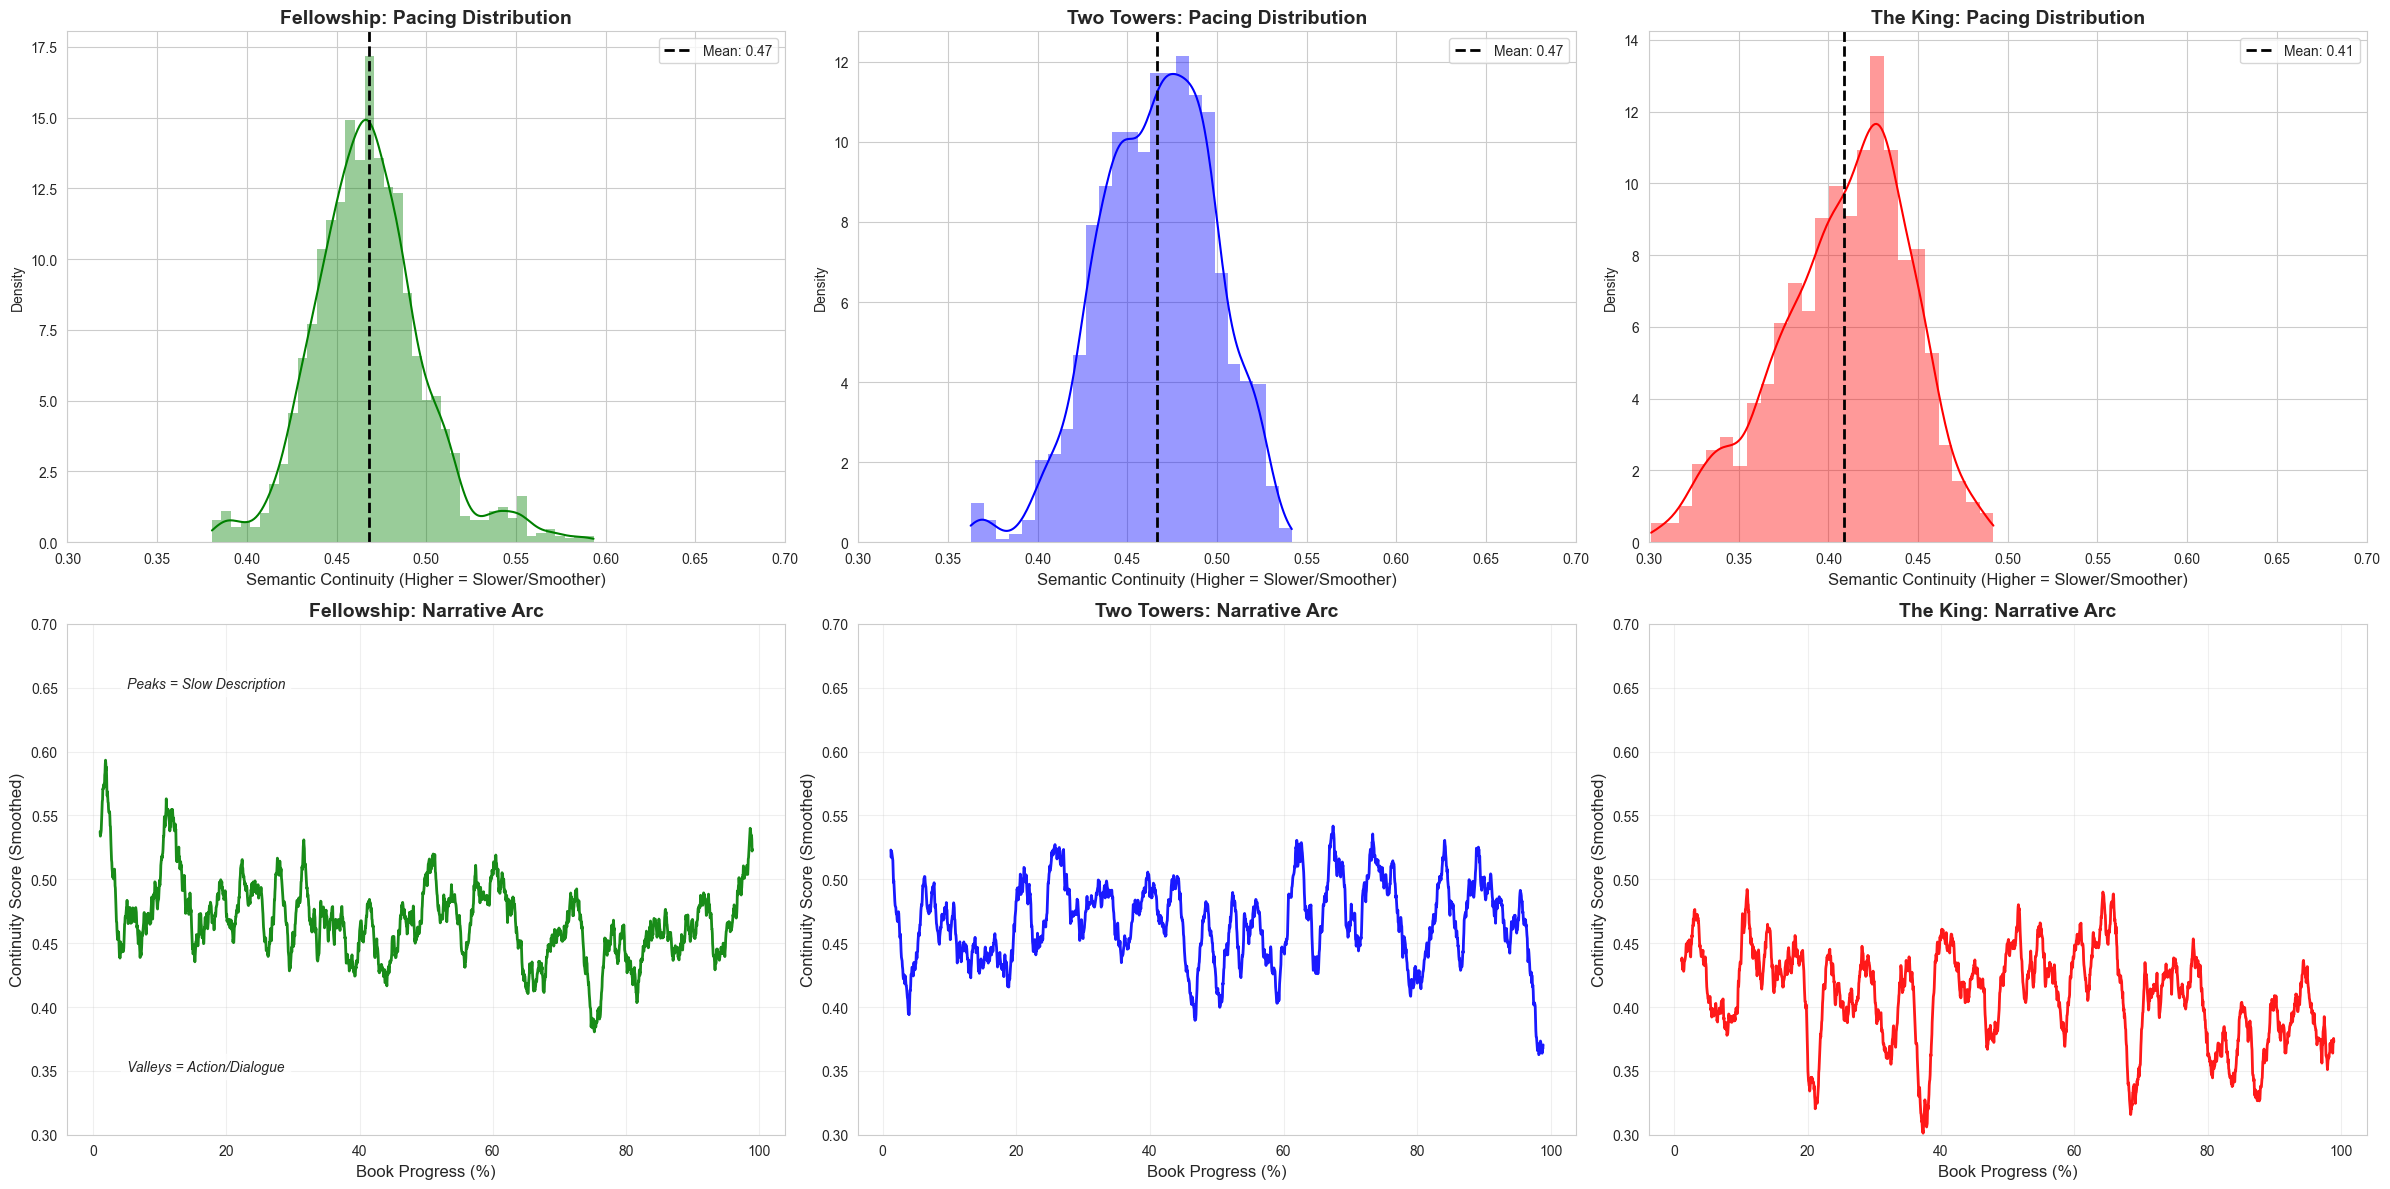

25675

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: ROBUST LOADING & SPLITTING ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Aggressive)
    Splits on every newline to handle all formatting types safely.
    """
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    # Strategy 1: Standard Split
    paras = re.split(r'\n\s*\n+', text)
    # Strategy 2: Fallback for dense files (The King)
    if len(paras) < 100:
        paras = text.split('\n')
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

# --- PART 2: DRIFT METRICS ---
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def calculate_drift(paragraphs: List[str]) -> List[float]:
    """
    Calculates the similarity between para[i] and para[i+1].
    High Score = Smooth Transition (Story continues).
    Low Score = Hard Cut (Topic Shift / New Scene).
    """
    if not paragraphs: return []
    
    # Batch encode for speed
    embs = model.encode(paragraphs)
    
    sims = []
    for i in range(len(embs) - 1):
        sim = cosine_similarity(embs[i], embs[i+1])
        sims.append(sim)
    return sims

def get_smoothed_data(data: List[float], window: int = 50) -> List[float]:
    """
    Applies a Rolling Average to see the 'Narrative Arc'.
    Window=50 shows the trend over ~2 pages of text.
    """
    series = pd.Series(data)
    # Interpolate to fill small gaps, then smooth
    return series.interpolate().rolling(window=window, center=True).mean().tolist()

# --- PART 3: EXECUTION ---
books = [
    ('Fellowship', '../data/Fellowship.txt'),
    ('Two Towers', '../data/TwoTowers.txt'),
    ('The King', '../data/TheKing.txt')
]

results = {}

for name, path in books:
    print(f"Processing {name}...")
    paras = split_into_paragraphs(load_book(path))
    
    # 1. Calculate Raw Drift
    raw_drift = calculate_drift(paras)
    
    # 2. Smooth the data
    smooth_drift = get_smoothed_data(raw_drift, window=50)
    
    results[name] = {
        'smooth': smooth_drift,
        'raw': raw_drift
    }

# --- PART 4: VISUALIZATION (Narrative Arc) ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}
order = ['Fellowship', 'Two Towers', 'The King']

# ROW 1: DISTRIBUTION (KDE)
# Shows the "Pacing Profile"
for i, name in enumerate(order):
    ax = axes[0, i]
    data = results[name]['smooth']
    # Filter NaNs for plotting
    valid_data = [d for d in data if not np.isnan(d)]
    
    sns.histplot(valid_data, ax=ax, color=colors[name], kde=True, stat="density", linewidth=0, alpha=0.4)
    
    mean_val = np.mean(valid_data)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    ax.set_title(f"{name}: Pacing Distribution", fontsize=14, fontweight='bold')
    ax.set_xlabel("Semantic Continuity (Higher = Slower/Smoother)", fontsize=12)
    ax.set_xlim(0.3, 0.7) # Focus on the active range
    ax.legend()

# ROW 2: NARRATIVE ARC (Line Plots)
# The graph you requested: Shows the story shape over time
for i, name in enumerate(order):
    ax = axes[1, i]
    data = results[name]['smooth']
    color = colors[name]
    
    # Create X-axis as % of book
    x_axis = np.linspace(0, 100, len(data))
    
    ax.plot(x_axis, data, color=color, linewidth=2, alpha=0.9)
    
    ax.set_title(f"{name}: Narrative Arc", fontsize=14, fontweight='bold')
    ax.set_xlabel("Book Progress (%)", fontsize=12)
    ax.set_ylabel("Continuity Score (Smoothed)", fontsize=12)
    ax.set_ylim(0.3, 0.7)
    ax.grid(True, alpha=0.3)
    
    # Helper Text
    if i == 0:
        ax.text(5, 0.65, "Peaks = Slow Description", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))
        ax.text(5, 0.35, "Valleys = Action/Dialogue", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Cleanup
gc.collect()

Processing Fellowship...
Processing Two Towers...
Processing The King...


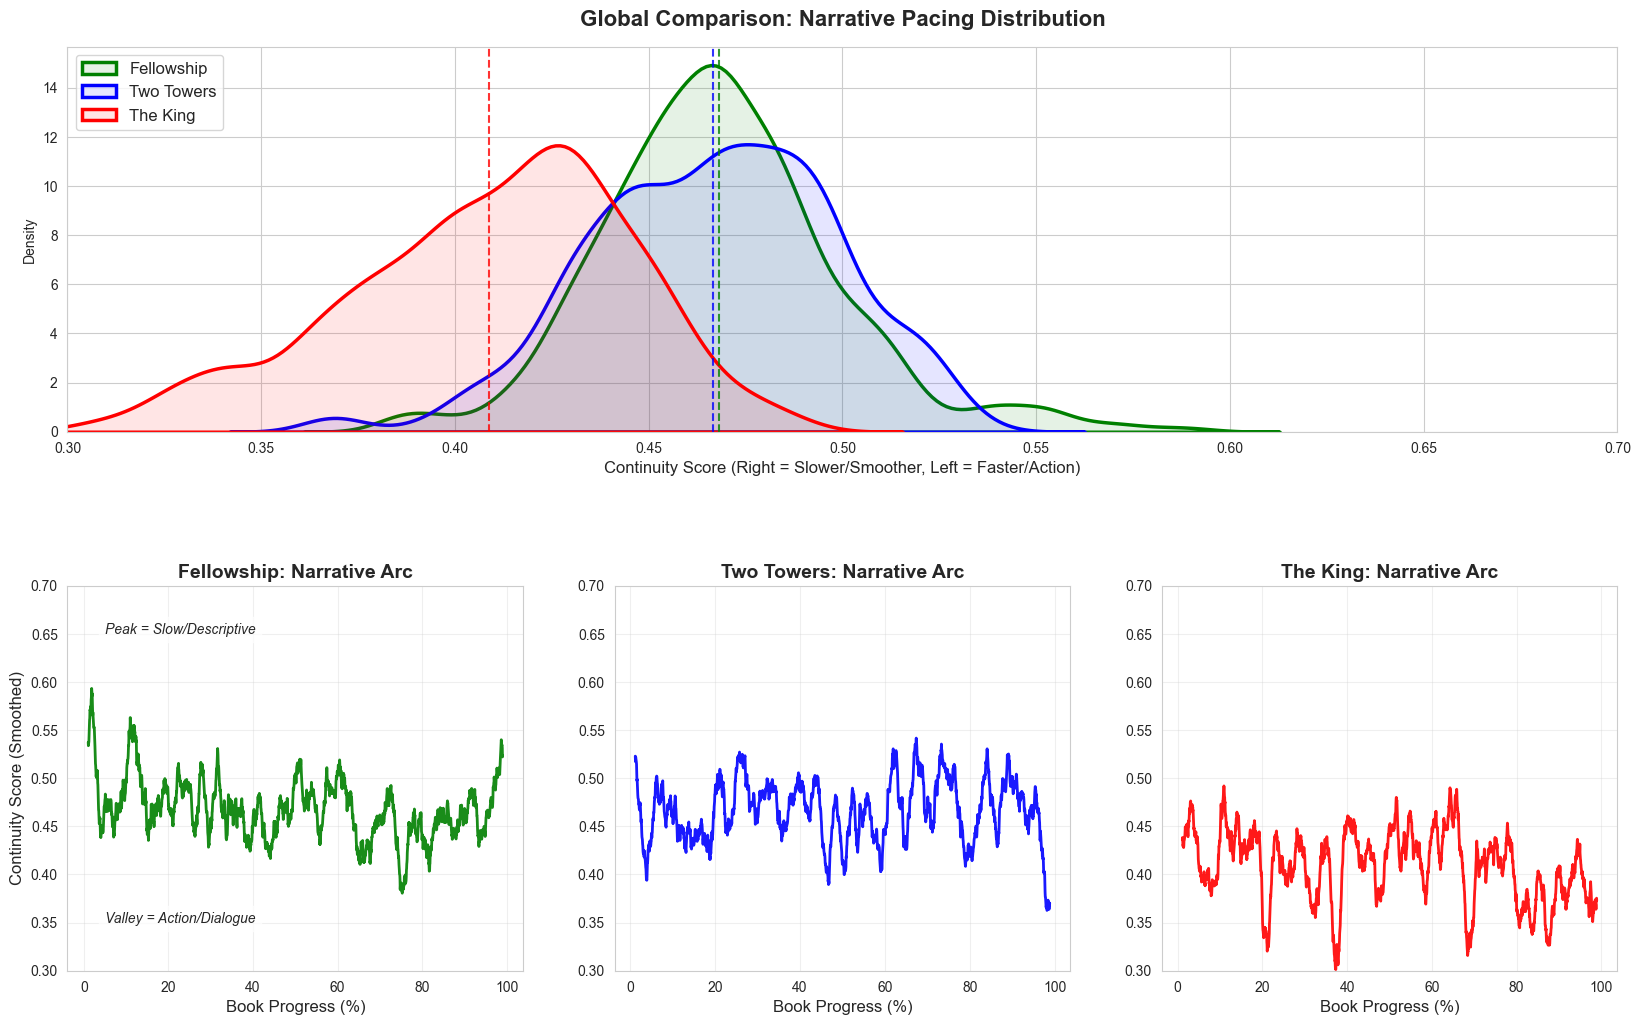

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: ROBUST LOADING & SPLITTING ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    paras = re.split(r'\n\s*\n+', text)
    if len(paras) < 100:
        paras = text.split('\n')
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

# --- PART 2: METRICS & SMOOTHING ---
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def calculate_drift(paragraphs: List[str]) -> List[float]:
    if not paragraphs: return []
    embs = model.encode(paragraphs)
    sims = []
    for i in range(len(embs) - 1):
        sim = cosine_similarity(embs[i], embs[i+1])
        sims.append(sim)
    return sims

def get_smoothed_data(data: List[float], window: int = 50) -> List[float]:
    series = pd.Series(data)
    # Rolling mean with interpolation for smooth lines
    return series.interpolate().rolling(window=window, center=True).mean().tolist()

# --- PART 3: EXECUTION ---
books = [
    ('Fellowship', '../data/Fellowship.txt'),
    ('Two Towers', '../data/TwoTowers.txt'),
    ('The King', '../data/TheKing.txt')
]

results = {}
for name, path in books:
    print(f"Processing {name}...")
    paras = split_into_paragraphs(load_book(path))
    raw_drift = calculate_drift(paras)
    smooth_drift = get_smoothed_data(raw_drift, window=50) # Window 50 = ~2 pages
    
    results[name] = {'smooth': smooth_drift}

# --- PART 4: THE COMBINED & SEPARATED VISUALIZATION ---
sns.set_style("whitegrid")

# Create a custom Grid Layout
fig = plt.figure(figsize=(20, 12))
# height_ratios=[1, 1] means top and bottom rows are equal height
# hspace=0.4 adds space between top and bottom so they don't crash
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.4) 

colors = {'Fellowship': 'green', 'Two Towers': 'blue', 'The King': 'red'}
order = ['Fellowship', 'Two Towers', 'The King']

# --- TOP GRAPH: COMBINED DISTRIBUTION (Comparision) ---
ax_top = fig.add_subplot(gs[0, :]) # Spans all 3 columns

for name in order:
    data = results[name]['smooth']
    # Filter NaNs for plotting
    valid_data = [d for d in data if not np.isnan(d)]
    
    # Plot smooth KDE
    sns.kdeplot(valid_data, ax=ax_top, color=colors[name], fill=True, 
                label=name, alpha=0.1, linewidth=2.5, clip=(0.2, 0.8))
    
    # Add Mean Line
    mean_val = np.mean(valid_data)
    ax_top.axvline(mean_val, color=colors[name], linestyle='--', linewidth=1.5, alpha=0.8)

ax_top.set_title('Global Comparison: Narrative Pacing Distribution', fontsize=16, fontweight='bold', pad=15)
ax_top.set_xlabel('Continuity Score (Right = Slower/Smoother, Left = Faster/Action)', fontsize=12)
ax_top.set_xlim(0.3, 0.7)
ax_top.legend(fontsize=12, loc='upper left')


# --- BOTTOM GRAPHS: SEPARATE NARRATIVE ARCS (Story Flow) ---
for i, name in enumerate(order):
    ax = fig.add_subplot(gs[1, i]) # One subplot per column
    
    data = results[name]['smooth']
    x_axis = np.linspace(0, 100, len(data))
    
    # Plot the Narrative Arc Line
    ax.plot(x_axis, data, color=colors[name], linewidth=2, alpha=0.9)
    
    ax.set_title(f"{name}: Narrative Arc", fontsize=14, fontweight='bold')
    ax.set_xlabel("Book Progress (%)", fontsize=12)
    
    # Only add Y-label to the first graph to keep it clean
    if i == 0:
        ax.set_ylabel("Continuity Score (Smoothed)", fontsize=12)
        # Add Helper Text
        ax.text(5, 0.65, "Peak = Slow/Descriptive", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))
        ax.text(5, 0.35, "Valley = Action/Dialogue", fontsize=10, style='italic', bbox=dict(facecolor='white', alpha=0.7))
        
    ax.set_ylim(0.3, 0.7)
    ax.grid(True, alpha=0.3)

plt.show() # tight_layout() is skipped because we manually set spacing
